In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [15]:
trainloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(datasets.MNIST('MNIST_data/', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           
                       ])) , list(range(0 , 60000 , 100))),
        batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           
                       ])),
        batch_size=64, shuffle=True)

In [39]:
len(trainloader)*16

15008

In [18]:
len(test_loader.dataset)

10000

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('cpu')

cuda


In [7]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return l  #k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) 

In [9]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return (test_loss ,correct / len(test_loader.dataset) )

In [10]:
def get_model():
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 400))
    model.add_module('r1', nn.Sigmoid())
    model.add_module('l2', nn.Linear(400, 400))
    model.add_module('r2', nn.Sigmoid())
    model.add_module('l3', nn.Linear(400, 400))
    model.add_module('r3', nn.Sigmoid())
    model.add_module('l4', nn.Linear(400, 400))
    model.add_module('r4', nn.Sigmoid())
    model.add_module('l5', nn.Linear(400, 400))
    model.add_module('r5', nn.Sigmoid())
    model.add_module('lf', nn.Linear(400, 10))

    model.to(device)
    return model

In [297]:
m_200 = 1
m_784 = 1
NUM_EPOCH = 200
model = get_model()

In [23]:
np.logspace(0 , 5 , 10)

array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05])

In [24]:
history_acc = []
history = []
for m_200 in np.logspace(0 , 5 , 10):
    NUM_EPOCH = 200
    model = get_model()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    loss_p = []
    for epoch in range(1, NUM_EPOCH):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
            loss_1 = call_pr_loss(model.l1.weight , m_200)
            loss_2 = call_pr_loss(model.l2.weight , m_200)
            loss_3 = call_pr_loss(model.l3.weight , m_200)
            loss_4 = call_pr_loss(model.l4.weight , m_200)
            loss_5 = call_pr_loss(model.l5.weight , m_200)
            #loss_f = call_pr_loss(model.lf.weight , m_200)


            loss = loss_0 + loss_1+ loss_2+ loss_3 +  loss_4 + loss_5 #+ loss_f
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            loss_p.append(loss_0.item())
            if step % 1000  == 0:
                print('var = {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                    m_200,
                    epoch, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))

    history_acc.append(eva(test_loader , model))
    history.append((loss_history , loss_p))

var = 1.0 Train Epoch: 100 [216/600 (90%)]	Loss: 2.294958 

Test set: Average loss: 0.0362, Accuracy: 1028/10000 (10%)

var = 3.5938136638046276 Train Epoch: 100 [216/600 (90%)]	Loss: 2.292208 

Test set: Average loss: 0.0362, Accuracy: 1028/10000 (10%)

var = 12.91549665014884 Train Epoch: 100 [216/600 (90%)]	Loss: 0.187644 

Test set: Average loss: 0.0290, Accuracy: 7195/10000 (72%)

var = 46.4158883361278 Train Epoch: 100 [216/600 (90%)]	Loss: 0.303501 

Test set: Average loss: 0.0242, Accuracy: 7593/10000 (76%)

var = 166.81005372000593 Train Epoch: 100 [216/600 (90%)]	Loss: 0.021097 

Test set: Average loss: 0.0240, Accuracy: 7663/10000 (77%)

var = 599.4842503189409 Train Epoch: 100 [216/600 (90%)]	Loss: 0.242127 

Test set: Average loss: 0.0233, Accuracy: 7653/10000 (77%)

var = 2154.4346900318847 Train Epoch: 100 [216/600 (90%)]	Loss: 0.145727 

Test set: Average loss: 0.0248, Accuracy: 7492/10000 (75%)

var = 7742.636826811277 Train Epoch: 100 [216/600 (90%)]	Loss: 0.167351 



In [36]:
his = []
for i in history_acc:
    his.append(i[1])

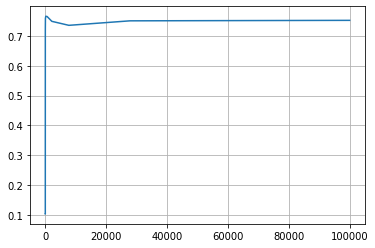

In [41]:
plt.figure()
plt.plot(np.logspace(0 , 5 , 10) , his)
plt.grid()
plt.show()

In [42]:
trainloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(datasets.MNIST('MNIST_data/', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           
                       ])) , list(range(0 , 60000 ))),
        batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           
                       ])),
        batch_size=64, shuffle=True)

In [43]:
history_acc = []
history = []
for m_200 in np.logspace(0 , 5 , 10):
    NUM_EPOCH = 5
    model = get_model()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    loss_p = []
    for epoch in range(1, NUM_EPOCH):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
            loss_1 = call_pr_loss(model.l1.weight , m_200)
            loss_2 = call_pr_loss(model.l2.weight , m_200)
            loss_3 = call_pr_loss(model.l3.weight , m_200)
            loss_4 = call_pr_loss(model.l4.weight , m_200)
            loss_5 = call_pr_loss(model.l5.weight , m_200)
            #loss_f = call_pr_loss(model.lf.weight , m_200)


            loss = loss_0 + loss_1+ loss_2+ loss_3 +  loss_4 + loss_5 #+ loss_f
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            loss_p.append(loss_0.item())
            if step % 1000  == 0:
                print('var = {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                    m_200,
                    epoch, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))

    history_acc.append(eva(test_loader , model))
    history.append((loss_history , loss_p))

var = 1.0 Train Epoch: 2 [3904/60000 (7%)]	Loss: 2.334471 
var = 1.0 Train Epoch: 3 [7872/60000 (13%)]	Loss: 2.312900 
var = 1.0 Train Epoch: 4 [11840/60000 (20%)]	Loss: 2.313036 

Test set: Average loss: 0.0362, Accuracy: 1135/10000 (11%)

var = 3.5938136638046276 Train Epoch: 2 [3904/60000 (7%)]	Loss: 2.308225 
var = 3.5938136638046276 Train Epoch: 3 [7872/60000 (13%)]	Loss: 2.312685 
var = 3.5938136638046276 Train Epoch: 4 [11840/60000 (20%)]	Loss: 2.307365 

Test set: Average loss: 0.0361, Accuracy: 1135/10000 (11%)

var = 12.91549665014884 Train Epoch: 2 [3904/60000 (7%)]	Loss: 0.402448 
var = 12.91549665014884 Train Epoch: 3 [7872/60000 (13%)]	Loss: 0.236617 
var = 12.91549665014884 Train Epoch: 4 [11840/60000 (20%)]	Loss: 0.067637 

Test set: Average loss: 0.0024, Accuracy: 9569/10000 (96%)

var = 46.4158883361278 Train Epoch: 2 [3904/60000 (7%)]	Loss: 0.445093 
var = 46.4158883361278 Train Epoch: 3 [7872/60000 (13%)]	Loss: 0.123638 
var = 46.4158883361278 Train Epoch: 4 [11840/

In [44]:
his = []
for i in history_acc:
    his.append(i[1])

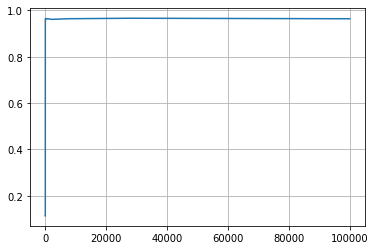

In [45]:
plt.figure()
plt.plot(np.logspace(0 , 5 , 10) , his)
plt.grid()
plt.show()